# Layered Embeddings

## Initialise

In [1]:
!pip install graphdatascience python-dotenv umap-learn scikit-learn==1.4.2 matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience, Graph

def drop_graph_if_exists(gds: GraphDataScience,
                         projections: list):
  """Drop named GDS projections in list.

  Args:
    gds : GraphDataScience
      Neo4j GDS session object
    projections: list
      List of projection names
  """
  # Check for existence of each named projection
  filtered_projections = list(filter(lambda x: x in projections, gds.graph.list()['graphName']))
  # Drop projections
  _ = list(map(lambda x: gds.graph.drop(gds.graph.get(x)), filtered_projections))


def reduce_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', reduce_column='reduced'):
  # Apply dimensionality reduction algorithm to embedding
  transformed = algorithm.fit_transform(np.array(list(df[property_column])))

  # Concatenate reduced transformation into Dataframe
  dfX = pd.concat([df, pd.Series(list(transformed))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [reduce_column], axis=1)
  return dfX


def cluster_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', cluster_column='cluster'):
  # Apply clustering algorithm to embedding
  algorithm.fit(np.array(list(df[property_column])))

  # Concatenate cluster labels into Dataframe
  dfX = pd.concat([df, pd.DataFrame(list(algorithm.labels_))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [cluster_column], axis=1)
  return dfX


def node_property_project(gds: GraphDataScience, projection_name: str, df: pd.DataFrame, nodeId_column: str, property_columns: list, labels: list):
  # Create empty DataFrame for nodes
  nodes = pd.DataFrame()

  # Set nodeId column
  nodes['nodeId'] = df[nodeId_column]

  # Add property columns to nodes dataframe
  for v in property_columns:
    nodes[v] = df[v]

  # Add a column for node labels
  nodes['labels'] = nodes.apply(lambda x: labels, axis='columns')

  # Empty dataframe - we don't need any relationships
  relationships = pd.DataFrame()

  # Create graph projection of nodes & properties from dataframe
  return gds.graph.construct(projection_name, nodes, relationships)


In [3]:
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap

from dotenv import load_dotenv
import os
import random
import pandas as pd
pd.set_option('display.max_rows', 100)
load_dotenv()

NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )

from neo4j import GraphDatabase
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)
n4j = driver.session(database=NEO4J_DB)


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

## Create Graph

In [4]:
nA = 2000
nB = 2000
nZ = 10
connections = 2

#nA = 2000
#nB = 2000
#nZ = 5
#connections = 3

nA = 10000
nB = 10000
nZ = 7
connections = 4

n4j.run('MATCH (n) DETACH DELETE n')

n4j.run("CREATE CONSTRAINT a_name IF NOT EXISTS FOR (n:A) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT b_name IF NOT EXISTS FOR (n:B) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT z_name IF NOT EXISTS FOR (n:Z) REQUIRE (n.name) IS UNIQUE")

n4j.run("UNWIND $records AS row MERGE (:A {name: row})", records=list(range(nA)))
n4j.run("UNWIND $records AS row MERGE (:B {name: row})", records=list(range(nB)))
n4j.run("UNWIND $records AS row MERGE (:Z {name: row})", records=list(range(nZ)))

n4j.run("UNWIND $records AS row MATCH (a:A {name: row}) MATCH (b:B {name: row}) MERGE (a)-[:FOLLOW]->(b)", records=list(range(nA)))

# Generate random traits
traits = list(map(lambda x: [x, random.sample(range(nZ), connections)], range(nA)))

n4j.run("UNWIND $records AS row MATCH (b:B {name: row[0]}) UNWIND row[1] AS x MATCH (z:Z {name: x}) MERGE (b)-[:TRAIT]->(z)", records=traits)

## Approach A - Direct

### Project

In [7]:
PROJECTION1 = 'ABZ'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION1], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    //MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

G, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION1)
result
gds.graph.list()
import time
time.sleep(5)

### Embed

In [8]:
EMBEDDING1 = 'fastRP1'
EMBEDDING_DIMENSION = 128
RANDOM_SEED = 42
GA = gds.graph.get(PROJECTION1)
gds.fastRP.mutate(GA, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING1, randomSeed=RANDOM_SEED, nodeLabels=['B', 'Z'])

nodePropertiesWritten                                                10007
mutateMillis                                                             0
nodeCount                                                            10007
preProcessingMillis                                                      1
computeMillis                                                           42
configuration            {'randomSeed': 42, 'mutateProperty': 'fastRP1'...
Name: 0, dtype: object

### Stream B embeddings

In [9]:
dfBe = gds.graph.nodeProperty.stream(GA, EMBEDDING1, 'B')

### Cluster, reduce, cluster

In [10]:
%%time
dfBc = cluster_embedding(dfBe, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
dfBc = reduce_embedding(dfBc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
dfBc = cluster_embedding(dfBc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')

CPU times: user 1min 26s, sys: 707 ms, total: 1min 27s
Wall time: 24.2 s


### Raw Clusters

In [11]:
dfBc['raw'].value_counts()

raw
31    314
10    312
4     310
2     308
28    305
11    304
29    301
32    296
19    294
18    292
20    292
25    291
9     291
16    289
34    288
3     287
17    287
14    286
12    286
21    286
24    281
5     280
26    280
6     280
22    279
27    278
7     277
13    276
15    273
1     272
8     267
23    264
33    258
30    258
0     258
Name: count, dtype: int64

### UMAP Clusters

In [12]:
dfBc['umap'].value_counts()

umap
 11    314
 8     312
 18    310
 29    308
 12    305
 24    304
 0     301
 16    296
 2     294
 7     292
 32    292
 36    291
 5     291
 19    289
 21    288
 9     287
 10    286
 17    286
 3     286
 1     281
 4     280
 6     280
 20    280
 33    279
 30    278
 26    277
 35    276
 22    273
 27    272
 14    267
 28    264
 13    258
 31    258
 15    258
 39     88
-1      40
 34     30
 25     29
 37     29
 23     29
 40     22
 38     20
Name: count, dtype: int64

### UMAP Cluster Plot

<Axes: xlabel='x', ylabel='y'>

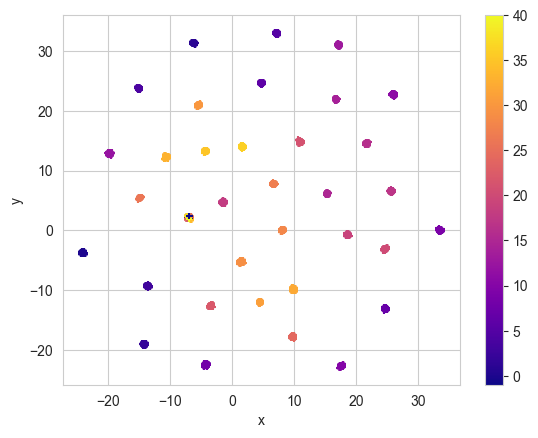

In [13]:
dfBc['x'] = dfBc['reduced'].apply(lambda x: x[0])
dfBc['y'] = dfBc['reduced'].apply(lambda x: x[1])
dfBc.plot.scatter(x='x', y='y', c=dfBc['umap'], cmap="plasma", marker='+')

## Approach B - Layered

### Project

In [14]:
PROJECTION2 = 'ABZ2'
PROJECTION3 = 'ABZ3'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION2, PROJECTION3], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    //MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

GB, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION2)
result

relationshipCount                                               100000
graphName                                                         ABZ2
query                \nCALL {\n    MATCH (a:A)-[r1:FOLLOW]->(b:B)\n...
projectMillis                                                       44
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                        20007
dtype: object

### Embed B to Z

In [15]:
EMBEDDING2 = 'fastRP2'
GB = gds.graph.get(PROJECTION2)
gds.fastRP.mutate(GB, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING2, nodeLabels=['B', 'Z'], randomSeed=RANDOM_SEED)

nodePropertiesWritten                                                10007
mutateMillis                                                             0
nodeCount                                                            10007
preProcessingMillis                                                      0
computeMillis                                                           28
configuration            {'randomSeed': 42, 'mutateProperty': 'fastRP2'...
Name: 0, dtype: object

### WCC for node property

In order to stream nodeIds a node must have a property - fix to add a property for A nodes.

In [16]:
gds.wcc.mutate(GB, mutateProperty='wcc')

mutateMillis                                                             0
nodePropertiesWritten                                                20007
componentCount                                                           1
componentDistribution    {'min': 20007, 'p5': 20007, 'max': 20007, 'p99...
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                            2
configuration            {'mutateProperty': 'wcc', 'jobId': 'aa895d67-7...
Name: 0, dtype: object

### Stream B embeddings

In [17]:
dfB2 = gds.graph.nodeProperty.stream(GB, EMBEDDING2, 'B')
dfB2['labels'] = dfB2.apply(lambda x: ['B'], axis='columns')
dfB2.head()

,nodeId,propertyValue,labels
0,1879,"[0.07392213, -0.14784425, 0.0, 0.07392213, 0.0...",[B]
1,1880,"[0.14396316, -0.07198158, 0.07198158, -0.07198...",[B]
2,1881,"[0.0747435, -0.0747435, 0.149487, 0.0747435, 0...",[B]
3,1882,"[0.07905694, -0.15811388, 0.0, 0.07905694, 0.0...",[B]
4,1883,"[0.0764719, -0.0764719, -0.0764719, 0.0764719,...",[B]


### Stream A nodes

Add zero vectors

In [18]:
dfA1 = gds.graph.nodeProperty.stream(GB, 'wcc', 'A')
dfA1['propertyValue'] = dfA1.apply(lambda x: list(map(lambda x: 0.0, range(EMBEDDING_DIMENSION))), axis='columns')
dfA1['labels'] = dfA1.apply(lambda x: ['A'], axis='columns')
dfA1.head()

,nodeId,propertyValue,labels
0,31893,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
1,31894,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
2,31895,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
3,31896,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
4,31897,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]


### Stream FOLLOW relationships

In [19]:
relationships = gds.graph.relationships.stream(GB, ['FOLLOW'])
relationships.head()

,sourceNodeId,targetNodeId,relationshipType
0,31893,1879,FOLLOW
1,1879,31893,FOLLOW
2,31894,1880,FOLLOW
3,1880,31894,FOLLOW
4,31895,1881,FOLLOW


### Construct Graph

In [20]:
PROPERTY_RATIO = 0.5
NODE_SELF_INFLUENCE = 0.0

list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION3], gds.graph.list()['graphName']))))
GC = gds.graph.construct(PROJECTION3, pd.concat([dfB2, dfA1]), relationships)

Uploading Nodes:   0%|          | 0/20000 [00:00<?, ?Records/s]

Uploading Relationships:   0%|          | 0/20000 [00:00<?, ?Records/s]

/Users/olgarazvenskaia/.env/fastrp-repr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'TopologyDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'TopologyDataFrame.transpose' instead.
  return bound(*args, **kwds)


### Embed combining graph & previously calculated embeddings

In [21]:
EMBEDDING3 = 'fastRP3'
gds.fastRP.mutate(GC, embeddingDimension=EMBEDDING_DIMENSION,
                  iterationWeights=[1.0], nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO, featureProperties=['propertyValue'], mutateProperty=EMBEDDING3)

nodePropertiesWritten                                                20000
mutateMillis                                                             0
nodeCount                                                            20000
preProcessingMillis                                                      0
computeMillis                                                           47
configuration            {'mutateProperty': 'fastRP3', 'jobId': 'b4218e...
Name: 0, dtype: object

### Stream A Embedding

In [22]:
dfA2 = gds.graph.nodeProperty.stream(GC, EMBEDDING3, 'A')
dfA2.describe()

,nodeId
count,10000.000000
mean,29373.869400
std,13842.484398
min,0.000000
25%,32513.750000
50%,35013.500000
75%,37513.250000
max,40013.000000


### Cluster, reduce, cluster

In [23]:
%%time
dfAc = cluster_embedding(dfA2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
dfAc = reduce_embedding(dfAc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
dfAc = cluster_embedding(dfAc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')

CPU times: user 37 s, sys: 431 ms, total: 37.5 s
Wall time: 10.3 s


### Raw Clusters

In [24]:
dfAc['raw'].value_counts()

raw
-1    8060
 1    1906
 2      22
 0      12
Name: count, dtype: int64

### UMAP Clusters

In [25]:
dfAc['umap'].value_counts()

umap
21    314
12    312
29    310
0     308
2     305
15    304
32    301
11    296
17    294
20    292
6     292
34    291
4     291
25    289
22    288
24    287
26    287
9     286
28    286
27    286
16    281
3     280
33    280
5     280
30    279
7     278
13    277
31    276
1     273
10    272
8     267
18    264
19    258
14    258
23    258
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

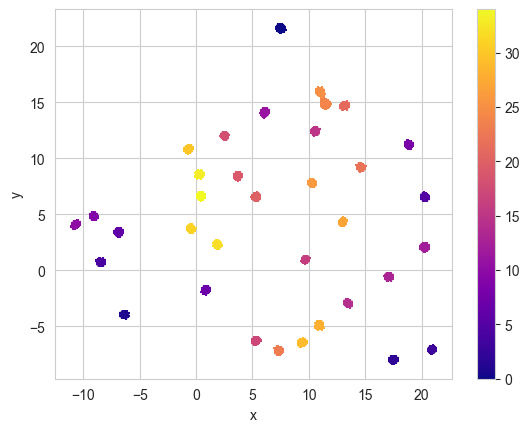

In [26]:
dfAc['x'] = dfAc['reduced'].apply(lambda x: x[0])
dfAc['y'] = dfAc['reduced'].apply(lambda x: x[1])
dfAc.plot.scatter(x='x', y='y', c=dfAc['umap'], cmap="plasma", marker='+')

In [27]:
relmap = dict(map(lambda x: (x['sourceNodeId'], x['targetNodeId']), relationships.to_dict(orient='records')))
dfAc['FOLLOW'] = dfAc.apply(lambda x: relmap[x['nodeId']], axis=1)

## Compare - Ovelap between clusters

The cluster membership of B nodes (B->Z embedding) should overlap with the cluster membership of the A node (A->B property embedding).

Maximal overlap is when the heatmap below has a red diagonal.

This is observed when propertyRatio = 0.5 (or exactly 1.0). Deviation from 0.5 toward 0.0 or 1.0 results in an embedding that carries little information from the original property embeddings (the cluster ovelap breaks down).

<Axes: >

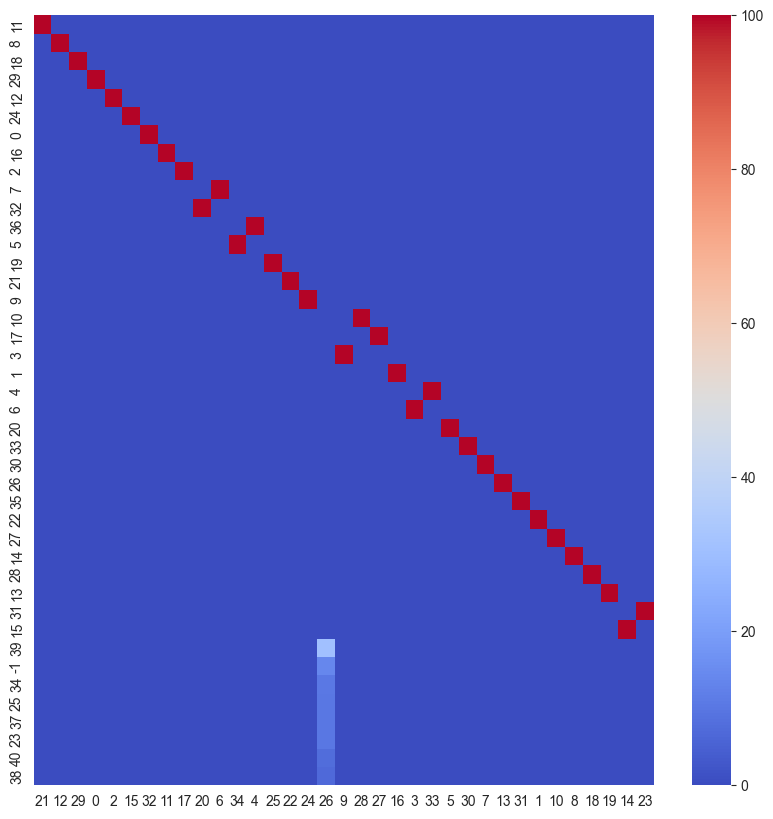

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

I = {}
for x in dfAc['umap'].value_counts().index:
  I[x] = {}
  for y in dfBc['umap'].value_counts().index:
    sA = set(dfAc[dfAc['umap'] == x]['FOLLOW'])
    sB = set(dfBc[dfBc['umap'] == y]['nodeId'])
    I[x][y] = 100 * len(sA & sB) / len(sA | sB)

fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(pd.DataFrame(I), cmap='coolwarm', annot=True, fmt=".0f")
sns.heatmap(pd.DataFrame(I), cmap='coolwarm')

## Close

In [29]:
#gds.graph.drop(G)
#gds.close()
#n4j.close()
#driver.close()